In [1]:
%load_ext autoreload
%autoreload 2

In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb
from concurrent.futures import ThreadPoolExecutor, as_completed
import dask.dataframe as dd
import sys
import glob
import os
from Bio.Seq import Seq

sys.path.append("../../scripts")
%aimport initial_map
%aimport map_refiner
%aimport complexity
%aimport finder
%aimport preprocess
%aimport complexity
%aimport plotting
%aimport umi_deduplicate
%aimport error_correct

from tqdm import tqdm  # progress bar

In [4]:
# UPDATE list of files and output location
AD_seq_files = glob.glob("/global/scratch/projects/fc_mvslab/OpenProjects/Caitlin/L4/TL4_results/data/RNA/a*")
RT_seq_files = glob.glob("/global/scratch/projects/fc_mvslab/OpenProjects/Caitlin/L4/TL4_results/data/RNA/r*")
output_path = "/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist_concat" # May need to change to your directory due to writing permissions

# Change below as needed to update barcode info, csv path to final step1 map, and desired output directory


step1_ADBC2 = finder.Barcode(name = "ADBC2",
                       preceder = "TATGCTAT",
                       post = "GGCCGGCCG",
                       length = 6)

step1_HawkBCs = finder.Barcode(name = "HawkBCs",
                       preceder = "TAGC",
                       post = "CTCGAGA",
                       length = 9)

step1_RTBC = finder.Barcode(name = "RTBC",
                       preceder = "GCCCC",
                       post = "GCGG",
                       length = 16)

# Step 1 map
step1_csv = "../../output/NKX2-2_whitelist_concat_density_step1_map.csv"  # Step 1 map I made with error correcting 

In [5]:
db_path = os.path.join(output_path, "NKX2-2_CC_UMI_whitelisted_concat.db")

In [6]:
AD_objects = [step1_ADBC2, step1_HawkBCs]

In [7]:
complex_AD_results = []
simple_AD_results = []

a2_RNA_ADBC_S18
/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist_concat/umi_a2_RNA_ADBC_S18
refining
Base prefix (stable across descriptors): umi_a2_RNA_ADBC_S18_ADBC2_HawkBCs_
Full prefix for this instance: umi_a2_RNA_ADBC_S18_ADBC2_HawkBCs_test_

Using the following step order:
1. initial
2. quality
3. error_corrected


Filtering to high-quality reads...
Created table: umi_a2_RNA_ADBC_S18_ADBC2_HawkBCs_test_quality — filtered for TRUE in all *_qual columns.
Done in 0.99 seconds.


=== Running error correction step on umi_a2_RNA_ADBC_S18_ADBC2_HawkBCs_test_quality ===

=== Applying whitelist for umi_a2_RNA_ADBC_S18 ===
Generating FASTQ: /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist_concat/umi_a2_RNA_ADBC_S18/umi_a2_RNA_ADBC_S18_ADBC2_HawkBCs_filtered_barcodes_extracted.fastq
Wrote 769918 reads to /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist_c

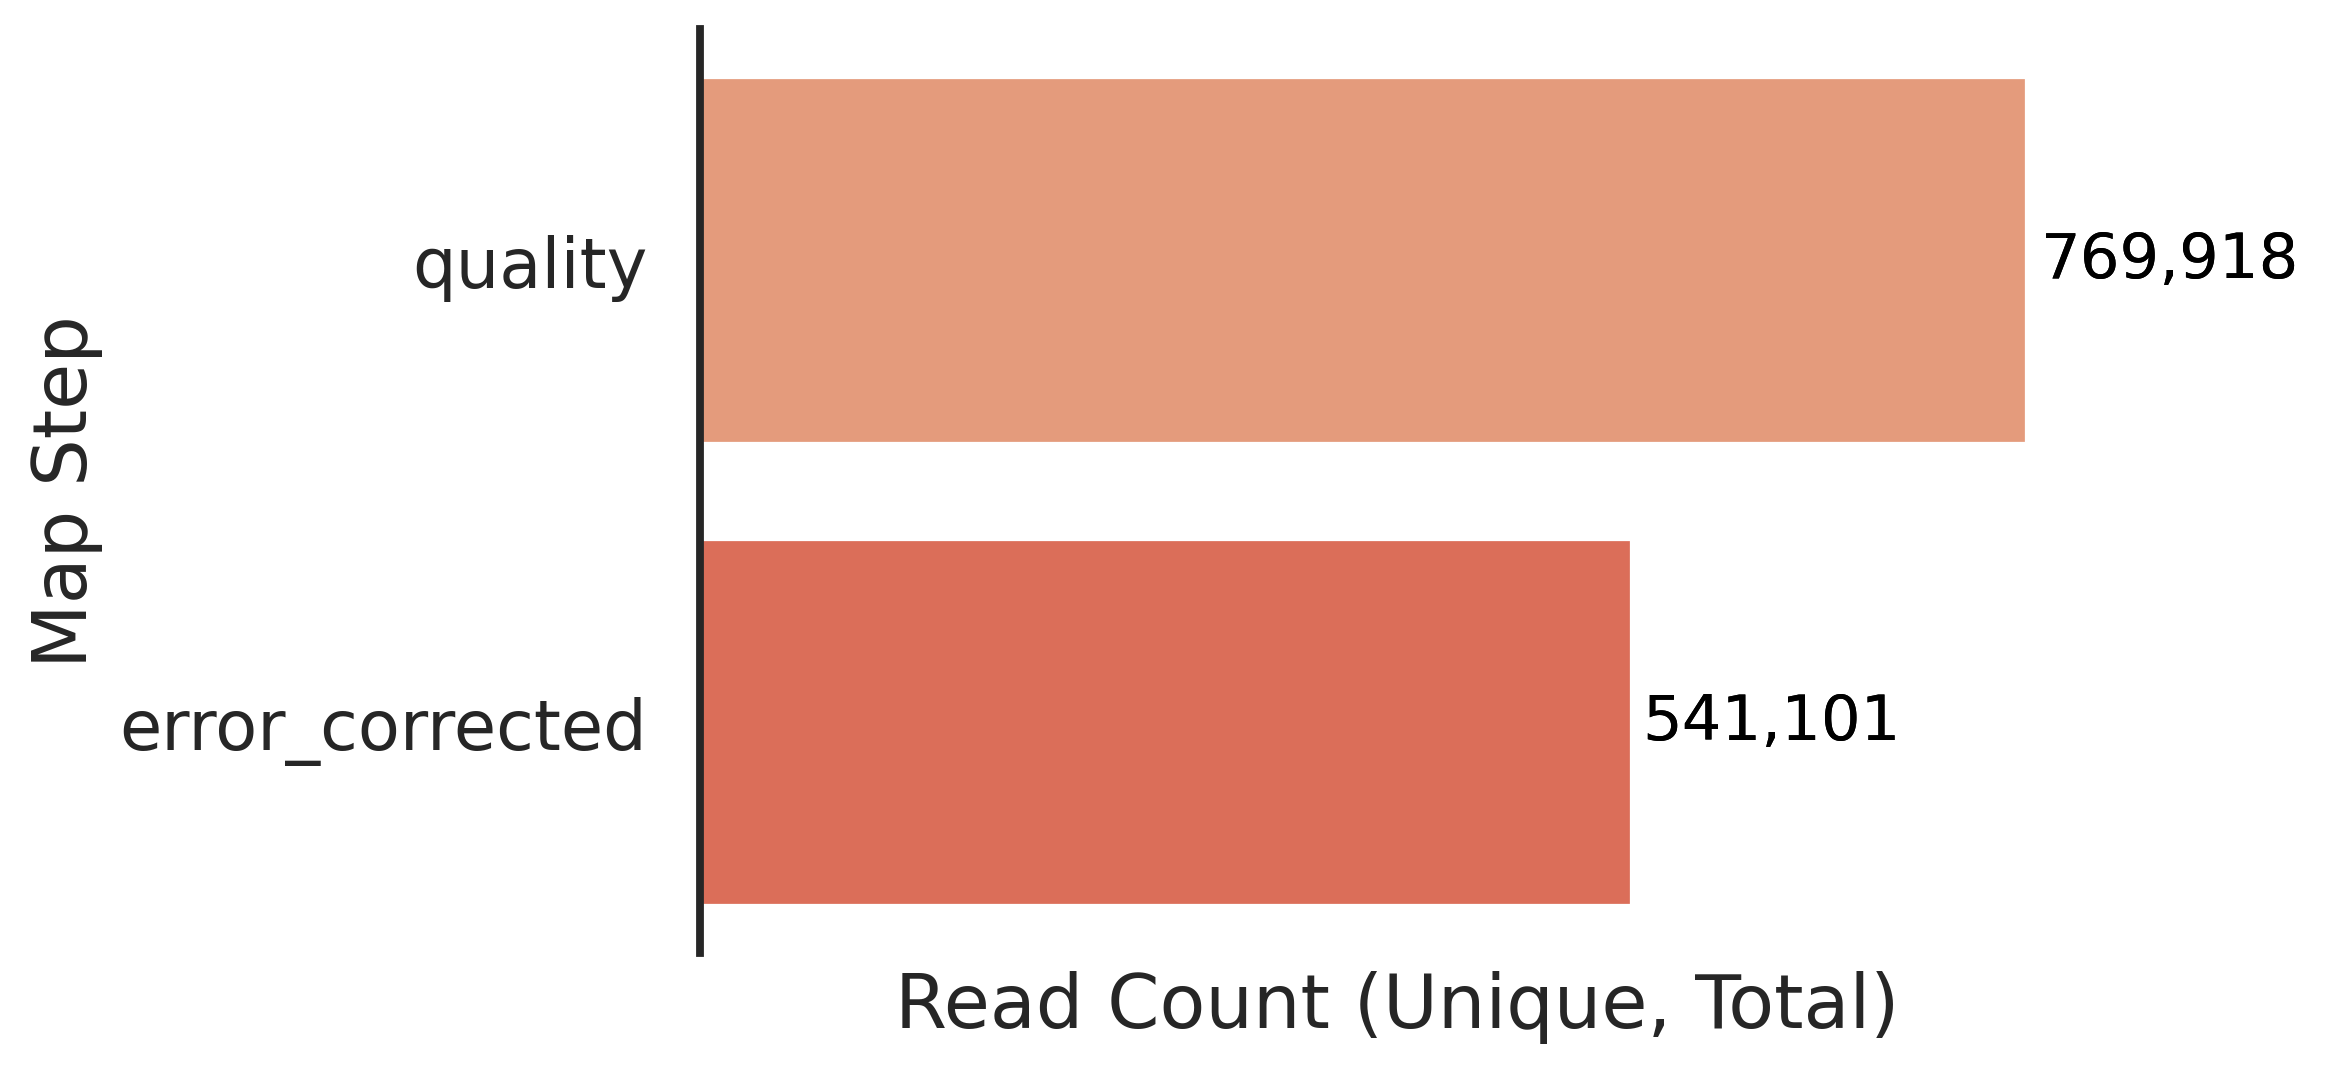

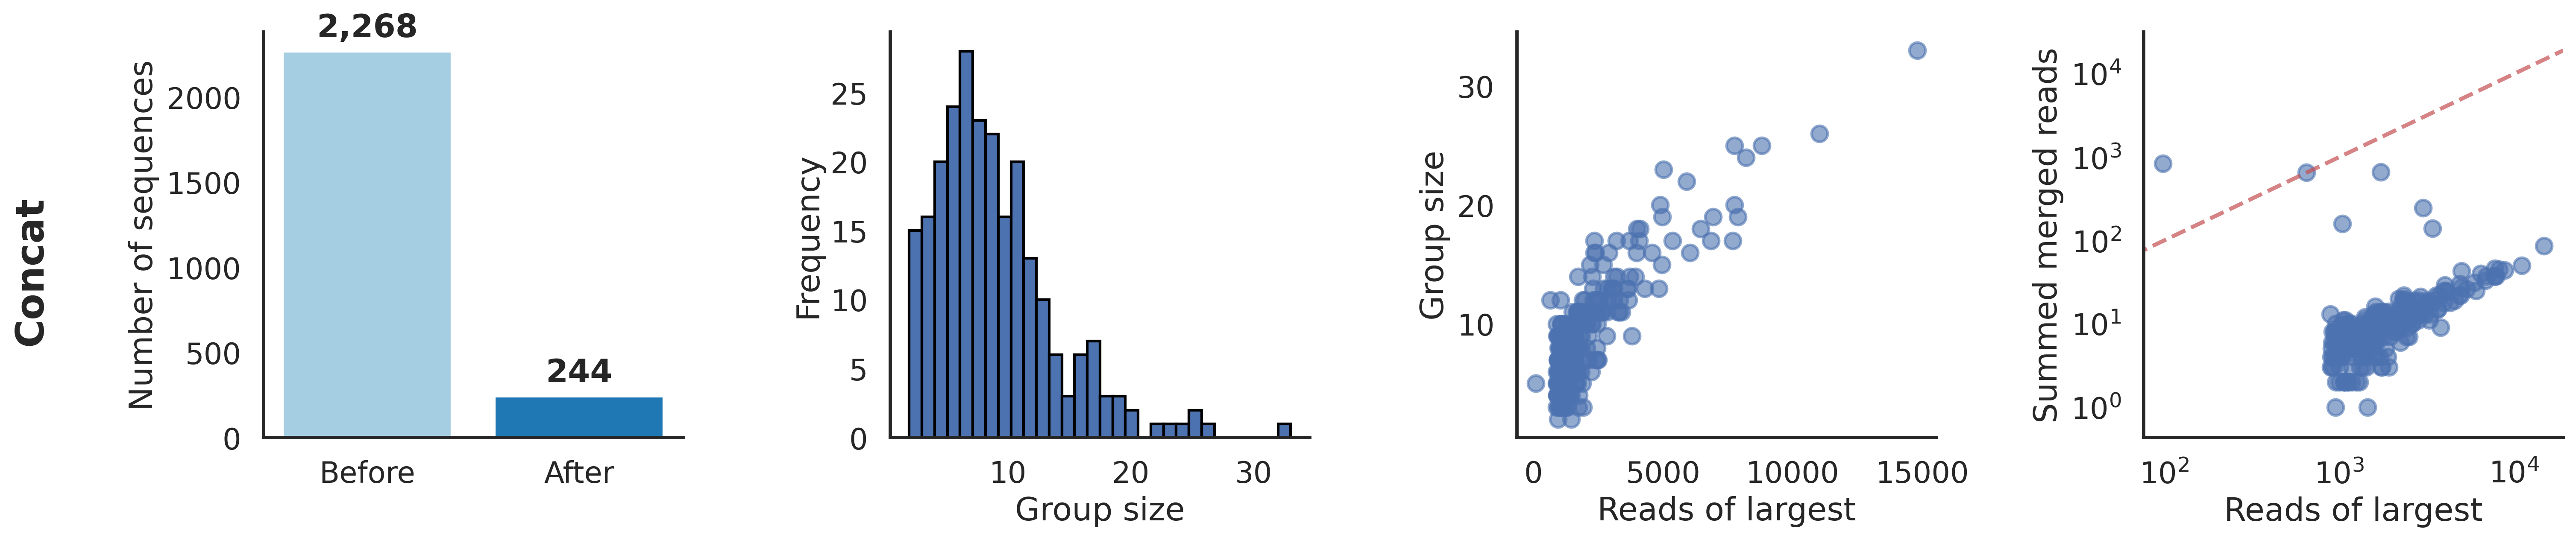

Done in 2.79 seconds.

244


In [155]:
file_path = AD_seq_files[0]

# Get the file naeme to use for database
base_name = os.path.basename(file_path)
name_only = base_name.split('.')[0]
print(name_only) 

# Get the file naeme to use for output
umi_path = os.path.join(output_path, f"umi_{name_only}")
print(umi_path)

# Extract UMIs and barcodes from reads
# umi_mapper = initial_map.InitialMapper(db_path = db_path,
#                                    step_name = f"umi_{name_only}", 
#                                    seq_file = file_path,
#                                    design_file_path = None,
#                                    bc_objects = AD_objects,
#                                    reverse_complement = True,
#                                    umi_length = 12)
# umi_mapper.create_map()

print("refining")
# Only keep barcodes of correct length, then error correct
refiner = map_refiner.MapRefiner(db_path = db_path,
                                    bc_objects=AD_objects,
                                    column_pairs = [],
                                    reads_threshold = 1,
                                    map_order = ['quality', 'error_corrected'],
                                    step_name=f"umi_{name_only}", 
                                    descriptor = "test",
                                output_figures_path = umi_path, should_check_exists = False, design_check = False)
refiner.refine_map_from_db()
refiner.plot_loss()
refiner.plot_error_correction()
error_corrected = refiner.get_map_df('error_corrected')
print(len(error_corrected[["ADBC2", "HawkBCs"]].drop_duplicates()))

# # Run both deduplications
# deduplicator = umi_deduplicate.UMIDeduplicator(db_path = db_path,
#                                                     bc_objects = AD_objects,
#                                                     step_name = f"umi_{name_only}", 
#                                                     descriptor = "",
#                                                     step1_map_name = None,
#                                                     fastq_path = file_path,
#                                                     umi_length = 12,
#                                                     output_path = umi_path)

# deduplicator.run_both_deduplications()

# # Collect results
# one_file_complex_results = pd.read_csv(os.path.join(umi_path, f"{name_only}_directional_umi_counts.tsv"), sep = "\t")
# one_file_complex_results["name"] = name_only
# complex_AD_results.append(one_file_complex_results)

# one_file_simple_results = pd.read_csv(os.path.join(umi_path, f"{name_only}_simple_umi_counts.tsv"), sep = "\t")
# one_file_simple_results["name"] = name_only
# simple_AD_results.append(one_file_simple_results)

In [9]:
umi_a2_RNA_ADBC_S18_ADBC2_HawkBCs_quality = refiner.get_map_df('umi_a2_RNA_ADBC_S18_ADBC2_HawkBCs_quality')[["ADBC2", "HawkBCs"]]
umi_a2_RNA_ADBC_S18_ADBC2_HawkBCs_quality = pd.DataFrame(umi_a2_RNA_ADBC_S18_ADBC2_HawkBCs_quality.value_counts()).reset_index()
#umi_a2_RNA_ADBC_S18_ADBC2_HawkBCs_quality = umi_a2_RNA_ADBC_S18_ADBC2_HawkBCs_quality[umi_a2_RNA_ADBC_S18_ADBC2_HawkBCs_quality["count"] > 1]
umi_a2_RNA_ADBC_S18_ADBC2_HawkBCs_quality

,ADBC2,HawkBCs,count
0,GGTTAT,CACAACTTC,14898
1,CCATAA,CACCGATTG,11090
2,GCCTGT,CACAACTTC,8844
3,AGACTA,CACAACTTC,8245
4,CGAGTC,CACAACTTC,7915
...,...,...,...
5149,CAGTCA,CATCGGCGT,1
5150,CAGTCA,TATCAGCGT,1
5151,CAGTCC,ACGACCATA,1
5152,CAGTCT,ATAGTCCGC,1


In [14]:
# The curve below looks good, why do the densities look so weird?

<Axes: xlabel='count', ylabel='Count'>

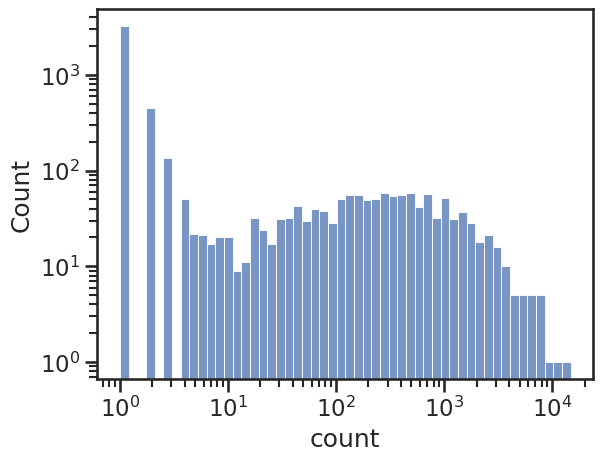

In [97]:
sns.set_style('ticks')
sns.histplot(umi_a2_RNA_ADBC_S18_ADBC2_HawkBCs_quality["count"], log_scale = (True, True))
#plt.xlim(1.5)

In [11]:
refiner.get_map_df('umi_a2_RNA_ADBC_S18_ADBC2_HawkBCs_quality')[["ADBC2", "HawkBCs"]]

,ADBC2,HawkBCs
0,AAATAA,AAGCTAAGG
1,TCGAGT,AGCAGTGTA
2,GATATT,CATAACAGG
3,ACTATT,CATTCCAAG
4,CCTAGC,CCAAGGTGT
...,...,...
769913,ACAAGA,AGATCGAAG
769914,CAAGGA,GACGGATTG
769915,CTGTAT,ATGGTATCC
769916,ATGATC,GATCGACTA


In [12]:
769918 * 4

3079672

In [18]:
# The extracted barcodes also have the correct length
extracted_barcodes = pd.read_csv("/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist_concat/umi_a2_RNA_ADBC_S18/umi_a2_RNA_ADBC_S18_ADBC2_HawkBCs_filtered_barcodes_extracted.fastq", header = None)
extracted_barcodes = extracted_barcodes.reset_index()
extracted_barcodes = extracted_barcodes[(extracted_barcodes["index"] % 4) == 1]
extracted_barcodes = extracted_barcodes.drop(columns = "index")
extracted_barcodes

,0
1,AAAATAAAAGCTAAGG
5,ATCGAGTAGCAGTGTA
9,AGATATTCATAACAGG
13,AACTATTCATTCCAAG
17,ACCTAGCCCAAGGTGT
...,...
3079653,AACAAGAAGATCGAAG
3079657,ACAAGGAGACGGATTG
3079661,ACTGTATATGGTATCC
3079665,AATGATCGATCGACTA


<Axes: xlabel='count', ylabel='Count'>

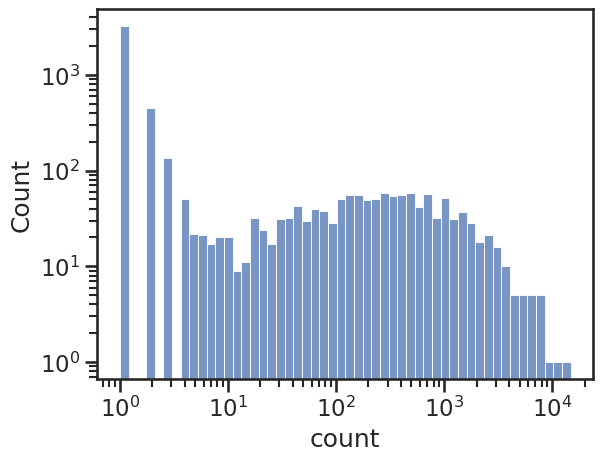

In [98]:
sns.histplot(extracted_barcodes[0].value_counts(), log_scale = (True, True))

# Let me try to recreate the density plot for a more well behaved dataset... step 1

In [23]:
step1_fastq = pd.read_csv("/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/notebooks/NKX2-2/error_corrected/step1_ADBC2_HawkBCs_RTBC_AD_filtered_barcodes_extracted.fastq", header = None)
step1_fastq = step1_fastq.reset_index()
step1_fastq = step1_fastq[(step1_fastq["index"] % 4) == 1]
step1_fastq = step1_fastq.drop(columns = "index")
step1_fastq

,0
1,ACAAGACATCGCCTTCTACAGGTTATCGTCAAGCCCAGGACCTGGC...
5,AGTTAAAATAAGCGCCCCAGATGCAATAGTTTGCTCCCGACCTGGC...
9,AATAACAACGCCTGAAAATATTTATCACTATTGCCCAGGACCTGGC...
13,AGCGTGTCCGAATTGAAATTACATAATACACGCCTCCCACCGACGT...
17,AGTAGGTCCACCTTACGATGGGAATAAATGGCCCCACCGACGTGAG...
...,...
11660001,AGGAGTGAGATCGAAGATACTTCGCAAGTGAGGCCCAGGACCTGGC...
11660005,ATACATTACCTGGAACAAACATTAGTAAATTTGCCCAGGACCTGGC...
11660009,AACGTCTAATGTTCGGTTGCATTAAAAGTTAAGCCCAGGACCTGGC...
11660013,AGTTTCACCATATTCGCTAATTAAGGTAGAAGGACTCTCCCGGACC...


In [36]:
step1_fastq_counts = pd.DataFrame(step1_fastq[0].value_counts())
step1_fastq_counts["log_count"] = np.log10(step1_fastq_counts["count"])
step1_fastq_counts

,count,log_count
0,,
ACCATAACACCGATTGCAGCGTTTAACAAGCGGCCGGCGACCTGGCCGCCGCCACCTTCGGCGCCGGCATTCCCTTCAGCGCCTACAGCGCCGGCAGCCTGGGCCACATGGGCTACAACGCCGGCTACAGCAGCGCCAGCACACCCGGCTATCCCACCGCCCATCCTCTGGTGGGCGCCGGCGGCTGGACCTGG,11172,4.048131
AGTCAGCCCATTAACGTGTAAAATGGGGCTGGGACTCTCCCGGACCCGGCTTCACACCTCACGACAGCGCTCCCTACGGCGCCATCGACATGGCCGACTTCGAGTTCGAGCAGATGTTCACCGACGCCATCGGCATCGACGAGTACGGCAGCGGCAGCGGCAGCGGCAGCGGCAGCGGCAGCGGCAGCGGCAGC,9261,3.966658
AGTACAACCATCGGTTTTGCAGAATAGCTGCAGACTCTCCCGGACCCGGCTTCACACCTCACGACAGCGCTCCCGCCGGCGCCCTGGACATGGCCGACTTCGAGTTCGAGCAGATGTTCACCGACGCCCTGGGCATCGACGAGGCCGGCAGCGGCAGCGGCAGCGGCAGCGGCAGCGGCAGCGGCAGCGGCAGC,7239,3.859679
ATGGGACACCGGATGTCACAAAACGTGGCGCCGCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCAGCGCCTACAGCGCCCAGAGCCTGCAGCACATGCAGTACAACGCCCAGTACAGCAGCGCCAGCACACCTCAGTATCCCACCGCCCATCCTCTGGTGTTCGCCCAGCAGTGGACCTGG,7042,3.847696
ACTAATAATCAGGACCCAGGAAATCCCTCTATGCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCGGCGCCTACGGCGCCCAGGGCCTGCAGCACATGCAGTACAACGCCCAGTACGGCGGCGCCGGCACACCTCAGTATCCCACCGCCCATCCTCTGGTGCAGGCCCAGCAGTGGACCTGG,6387,3.805297
...,...,...
ATATTTGCATTCGTACTACGTAGGCTTAAGTAACCGACTTCATCGACGAGGAGGTGTTCATGAGCTTCGTGATCGAGATGGGCTTCGACAGAATCAAGGAGTTTCCCGAGTTCTGGTTAGGCCAGAACGAGTTCGACTTCATGACCGACGGCAGCGGCAGCGGCAGCGGCAGCGGCAGCGGCAGCGGCAGCGGC,1,0.000000
AGGTTATCACAACTTCGATGGTAATGTGATAAGCCCTGGACCTGGCCGCCGCCACCTTCTTGGCCGGCATTCCCTTCAGCGCCTACAGCGCCCTGAGCCTGCTGCACATGCTGTACAACGCCCTGTACAGCAGCGCCAGCACACCTCTGTATCCCACCGCCCATCCTCTGGTGCTGGCCCTGCTGTGGACCTGG,1,0.000000
ACAAAAACATGTTGCCGTTTCTGTGTAGTCTAGCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCTGCATTCCCTGAAGCGCCTACAGCGCCCAGAGCCTGCAGCACATGCAGTACAACGCCCAGTACAGCAGCGCCAGCACACCTCAGTATCCCACCGGCCATCCTCTGGTGCAGGCCCAGCAGTGGACCTGG,1,0.000000


<Axes: xlabel='count', ylabel='Count'>

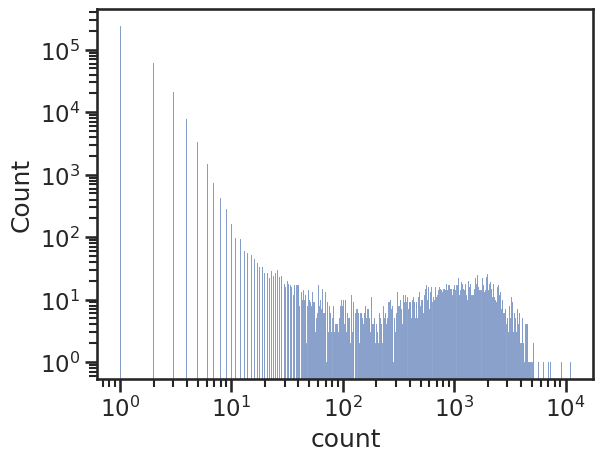

In [99]:
sns.histplot(step1_fastq_counts["count"], log_scale = (True, True))

<Axes: xlabel='log_count', ylabel='Density'>

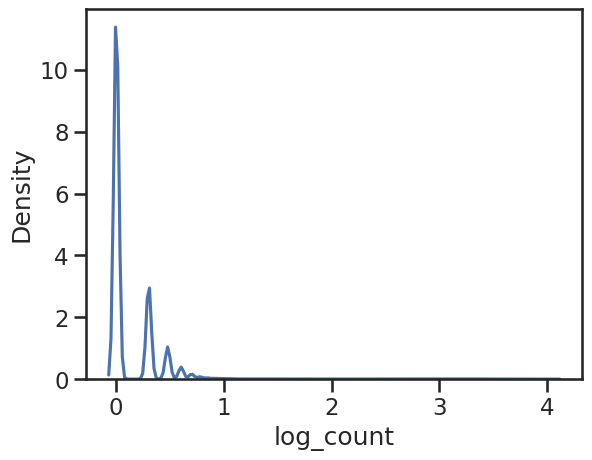

In [100]:
sns.kdeplot(step1_fastq_counts["log_count"])

In [55]:
step1_fastq_counts[step1_fastq_counts["log_count"] > 1]

,count,log_count
0,,
ACCATAACACCGATTGCAGCGTTTAACAAGCGGCCGGCGACCTGGCCGCCGCCACCTTCGGCGCCGGCATTCCCTTCAGCGCCTACAGCGCCGGCAGCCTGGGCCACATGGGCTACAACGCCGGCTACAGCAGCGCCAGCACACCCGGCTATCCCACCGCCCATCCTCTGGTGGGCGCCGGCGGCTGGACCTGG,11172,4.048131
AGTCAGCCCATTAACGTGTAAAATGGGGCTGGGACTCTCCCGGACCCGGCTTCACACCTCACGACAGCGCTCCCTACGGCGCCATCGACATGGCCGACTTCGAGTTCGAGCAGATGTTCACCGACGCCATCGGCATCGACGAGTACGGCAGCGGCAGCGGCAGCGGCAGCGGCAGCGGCAGCGGCAGCGGCAGC,9261,3.966658
AGTACAACCATCGGTTTTGCAGAATAGCTGCAGACTCTCCCGGACCCGGCTTCACACCTCACGACAGCGCTCCCGCCGGCGCCCTGGACATGGCCGACTTCGAGTTCGAGCAGATGTTCACCGACGCCCTGGGCATCGACGAGGCCGGCAGCGGCAGCGGCAGCGGCAGCGGCAGCGGCAGCGGCAGCGGCAGC,7239,3.859679
ATGGGACACCGGATGTCACAAAACGTGGCGCCGCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCAGCGCCTACAGCGCCCAGAGCCTGCAGCACATGCAGTACAACGCCCAGTACAGCAGCGCCAGCACACCTCAGTATCCCACCGCCCATCCTCTGGTGTTCGCCCAGCAGTGGACCTGG,7042,3.847696
ACTAATAATCAGGACCCAGGAAATCCCTCTATGCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCGGCGCCTACGGCGCCCAGGGCCTGCAGCACATGCAGTACAACGCCCAGTACGGCGGCGCCGGCACACCTCAGTATCCCACCGCCCATCCTCTGGTGCAGGCCCAGCAGTGGACCTGG,6387,3.805297
...,...,...
AGTAATCCAGCGGTATCCCCAGGCACTATAAGGCCCAGGACCTGGCCGCCGCCCAGTTCCAGGCCGGCATTCCCTTCAGCGCCTACAGCGCCCAGAGCCTGCAGCACATGCAGTACAACGCCCAGTACAGCAGCGCCAGCACACCTCAGTATCCCACCGCCCATCCTCTGGTGCAGGCCCAGCAGTGGACCTGG,11,1.041393
AAGCCCACCATCGGTTGAATAAGAATTTGCAGGACTCTCCAGGACCCGGCTTCACACCTCACGACAGCGCTCCCGCCGGCGCCCTGGACATGGCCGACTTCGAGTTCGAGCAGATGTTCACCGACGCCCTGGGCATCGACGAGGCCGGCAGCGGCAGCGGCAGCGGCAGCGGCAGCGGCAGCGGCAGCGGCAGC,11,1.041393
ACTTTGTCCACAGAACTGTAGATATGAGACTTAGACTGCTGGGCCAGAGCATGGACGAGAGCGGCCTGCCTCAGCTGACCAGCTACGACTGCGAGGTGAACGCTCCCATCCAGGGCAGCAGAAACCTGCTGCAGGGCGAGGAGCTGCTGAGAGCCCTGGACCAGGTGAACGGCAGCGGCAGCGGCAGCGGCAGC,11,1.041393


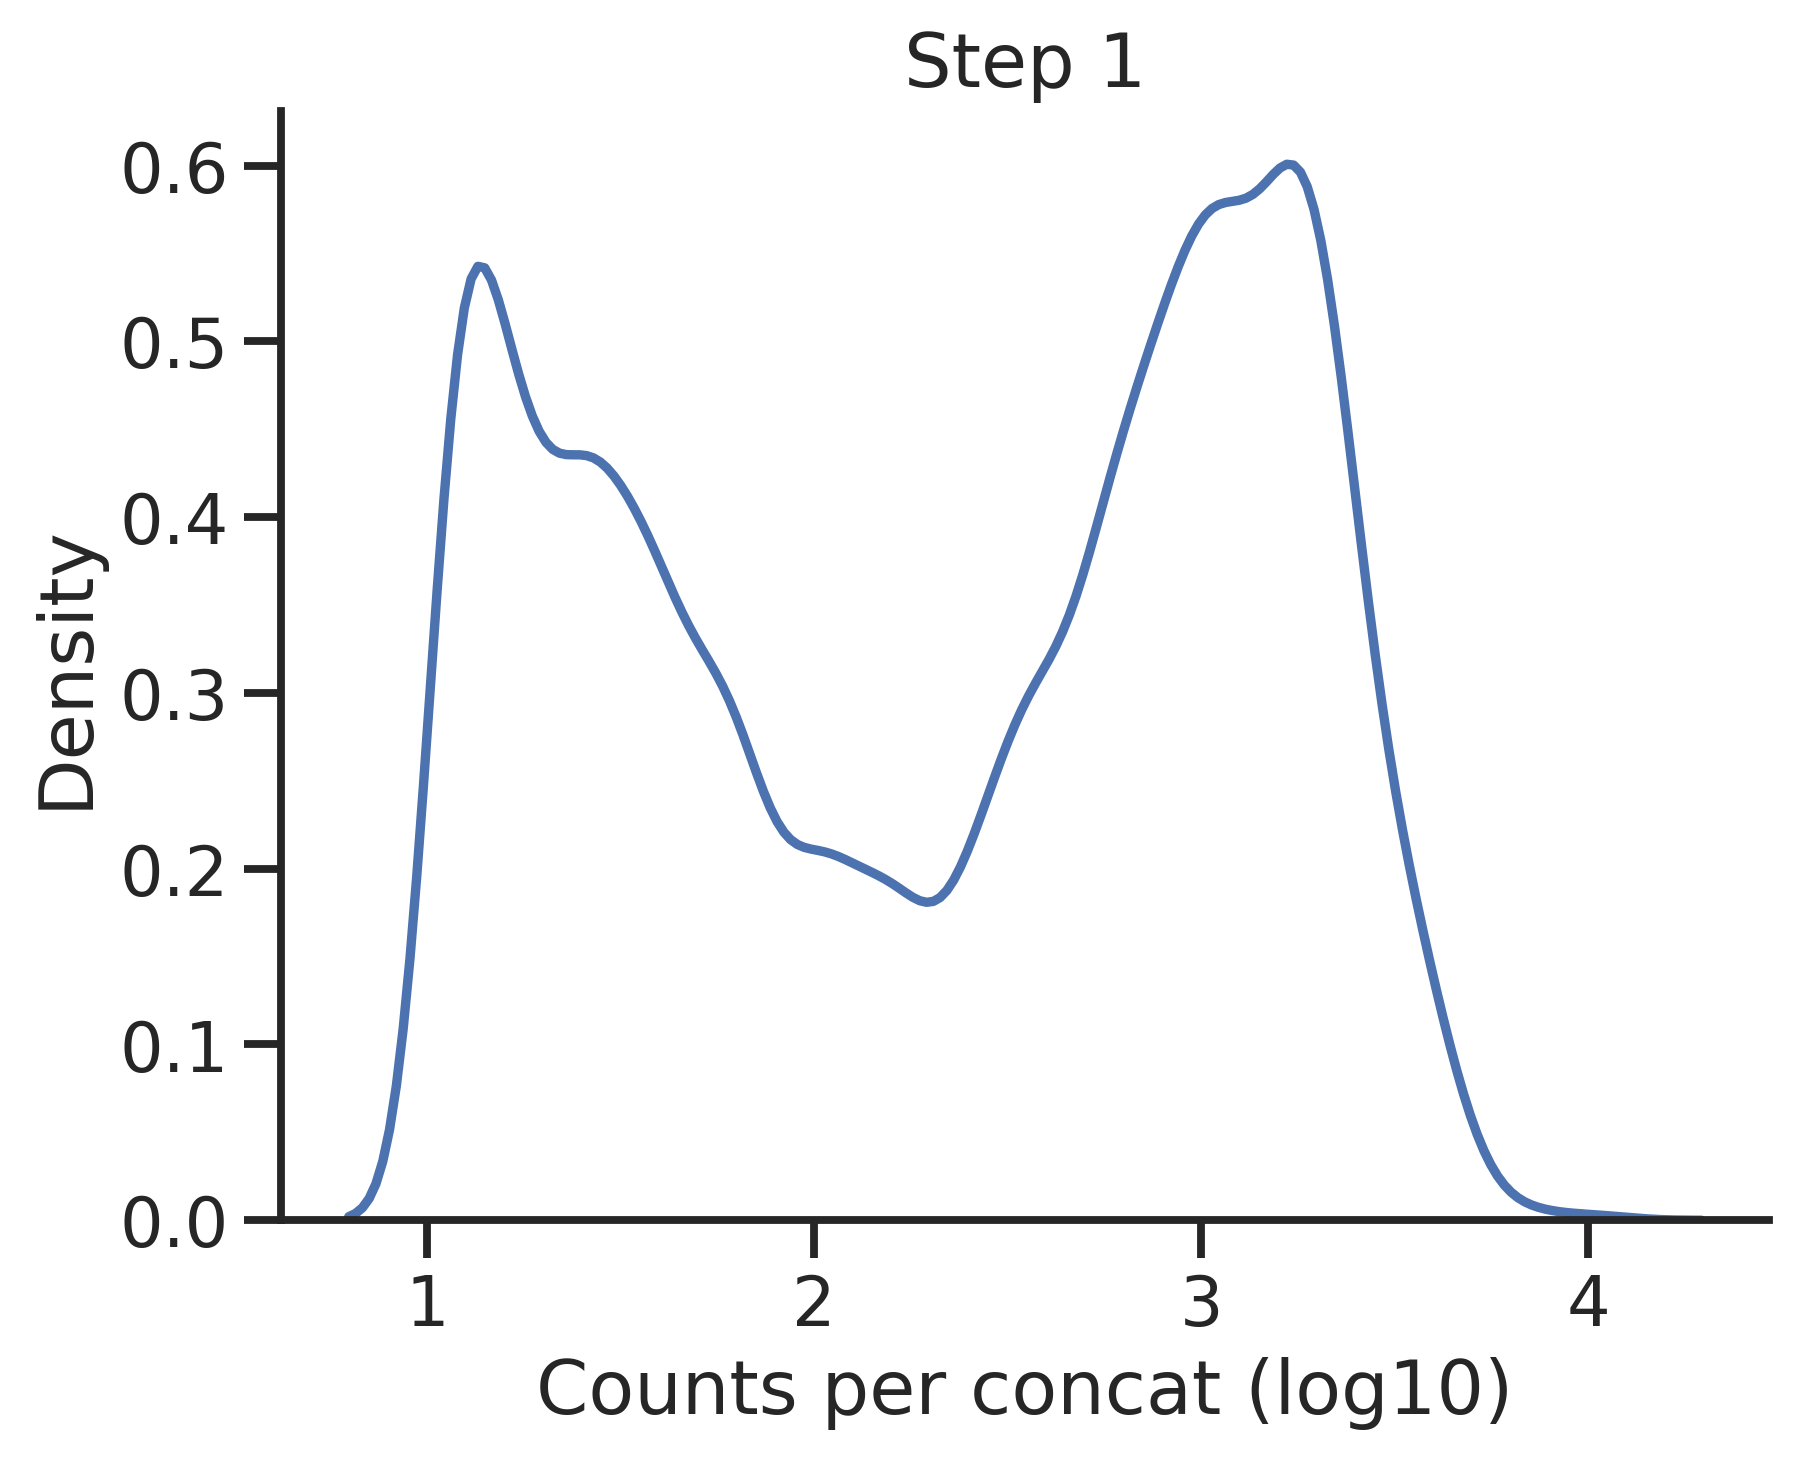

In [101]:
# Here is the strategy to get the same plot!
plt.figure(dpi = 300)
sns.set_context('talk')
plt.title("Step 1")
sns.kdeplot(step1_fastq_counts[step1_fastq_counts["log_count"] > 1]["log_count"], bw_adjust = 0.5)
plt.xlabel("Counts per concat (log10)")
sns.despine()

# Now let me try again with Caitlin's data

In [67]:
extracted_barcodes_counts = pd.DataFrame(extracted_barcodes[0].value_counts()).reset_index()
extracted_barcodes_counts["log_count"] = np.log10(extracted_barcodes_counts["count"])
extracted_barcodes_counts

,0,count,log_count
0,AGGTTATCACAACTTC,14898,4.173128
1,ACCATAACACCGATTG,11090,4.044932
2,AGCCTGTCACAACTTC,8844,3.946649
3,AAGACTACACAACTTC,8245,3.916191
4,ACGAGTCCACAACTTC,7915,3.898451
...,...,...,...
5149,ATCACTTAACCACGTG,1,0.000000
5150,AACGATTCACGACCTC,1,0.000000
5151,ACAAGTCCACAACTTC,1,0.000000
5152,ACGATCCCACAACTTC,1,0.000000


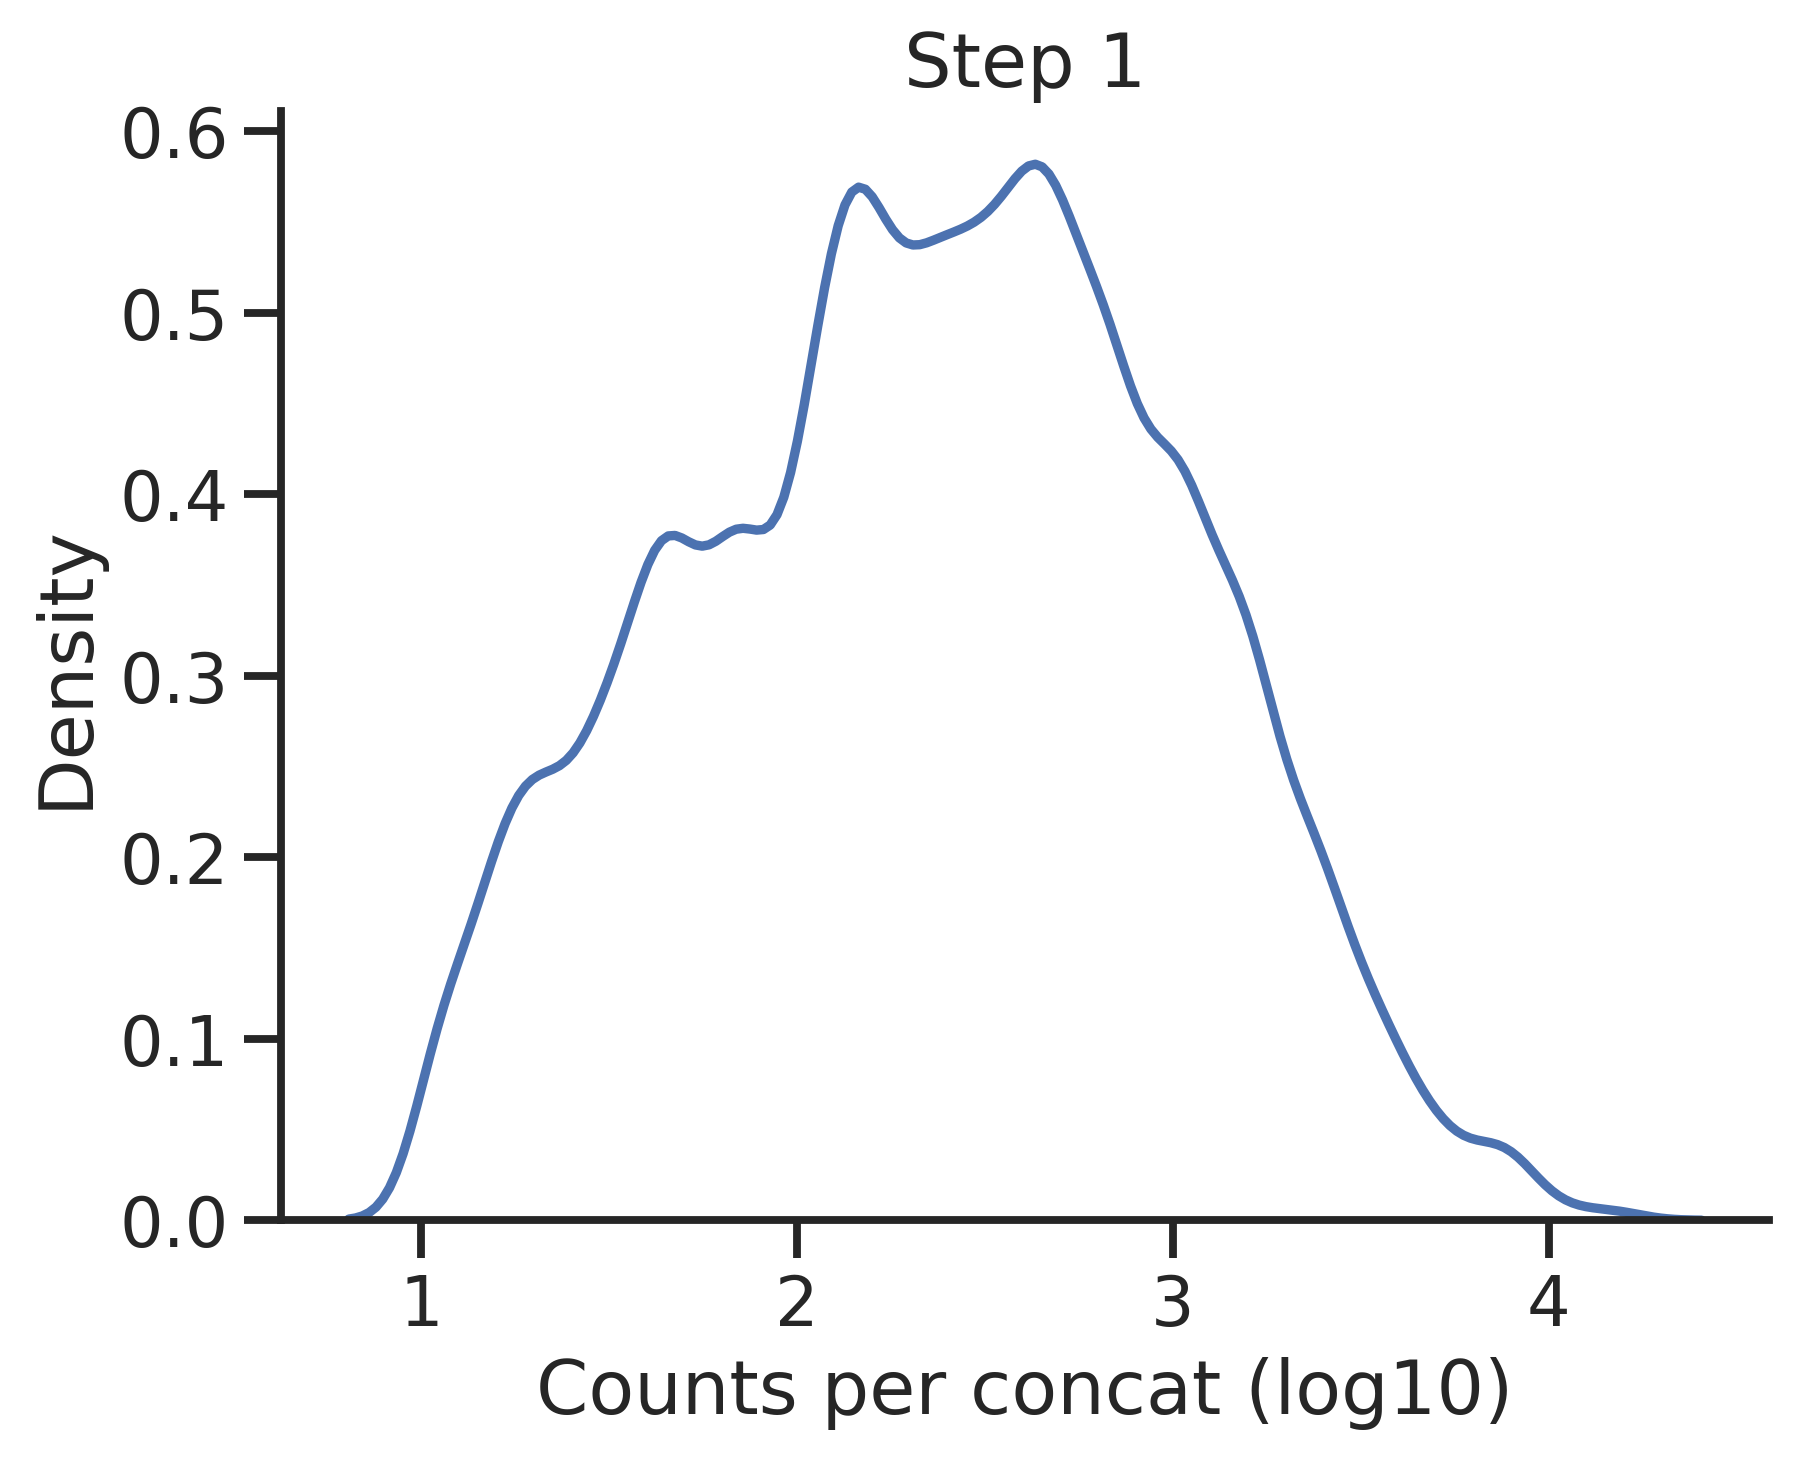

In [102]:
# Here is the strategy to get the same plot!
plt.figure(dpi = 300)
sns.set_context('talk')
plt.title("Step 1")
sns.kdeplot(extracted_barcodes_counts[extracted_barcodes_counts["log_count"] > 1]["log_count"], bw_adjust = 0.5)
plt.xlabel("Counts per concat (log10)")
sns.despine()

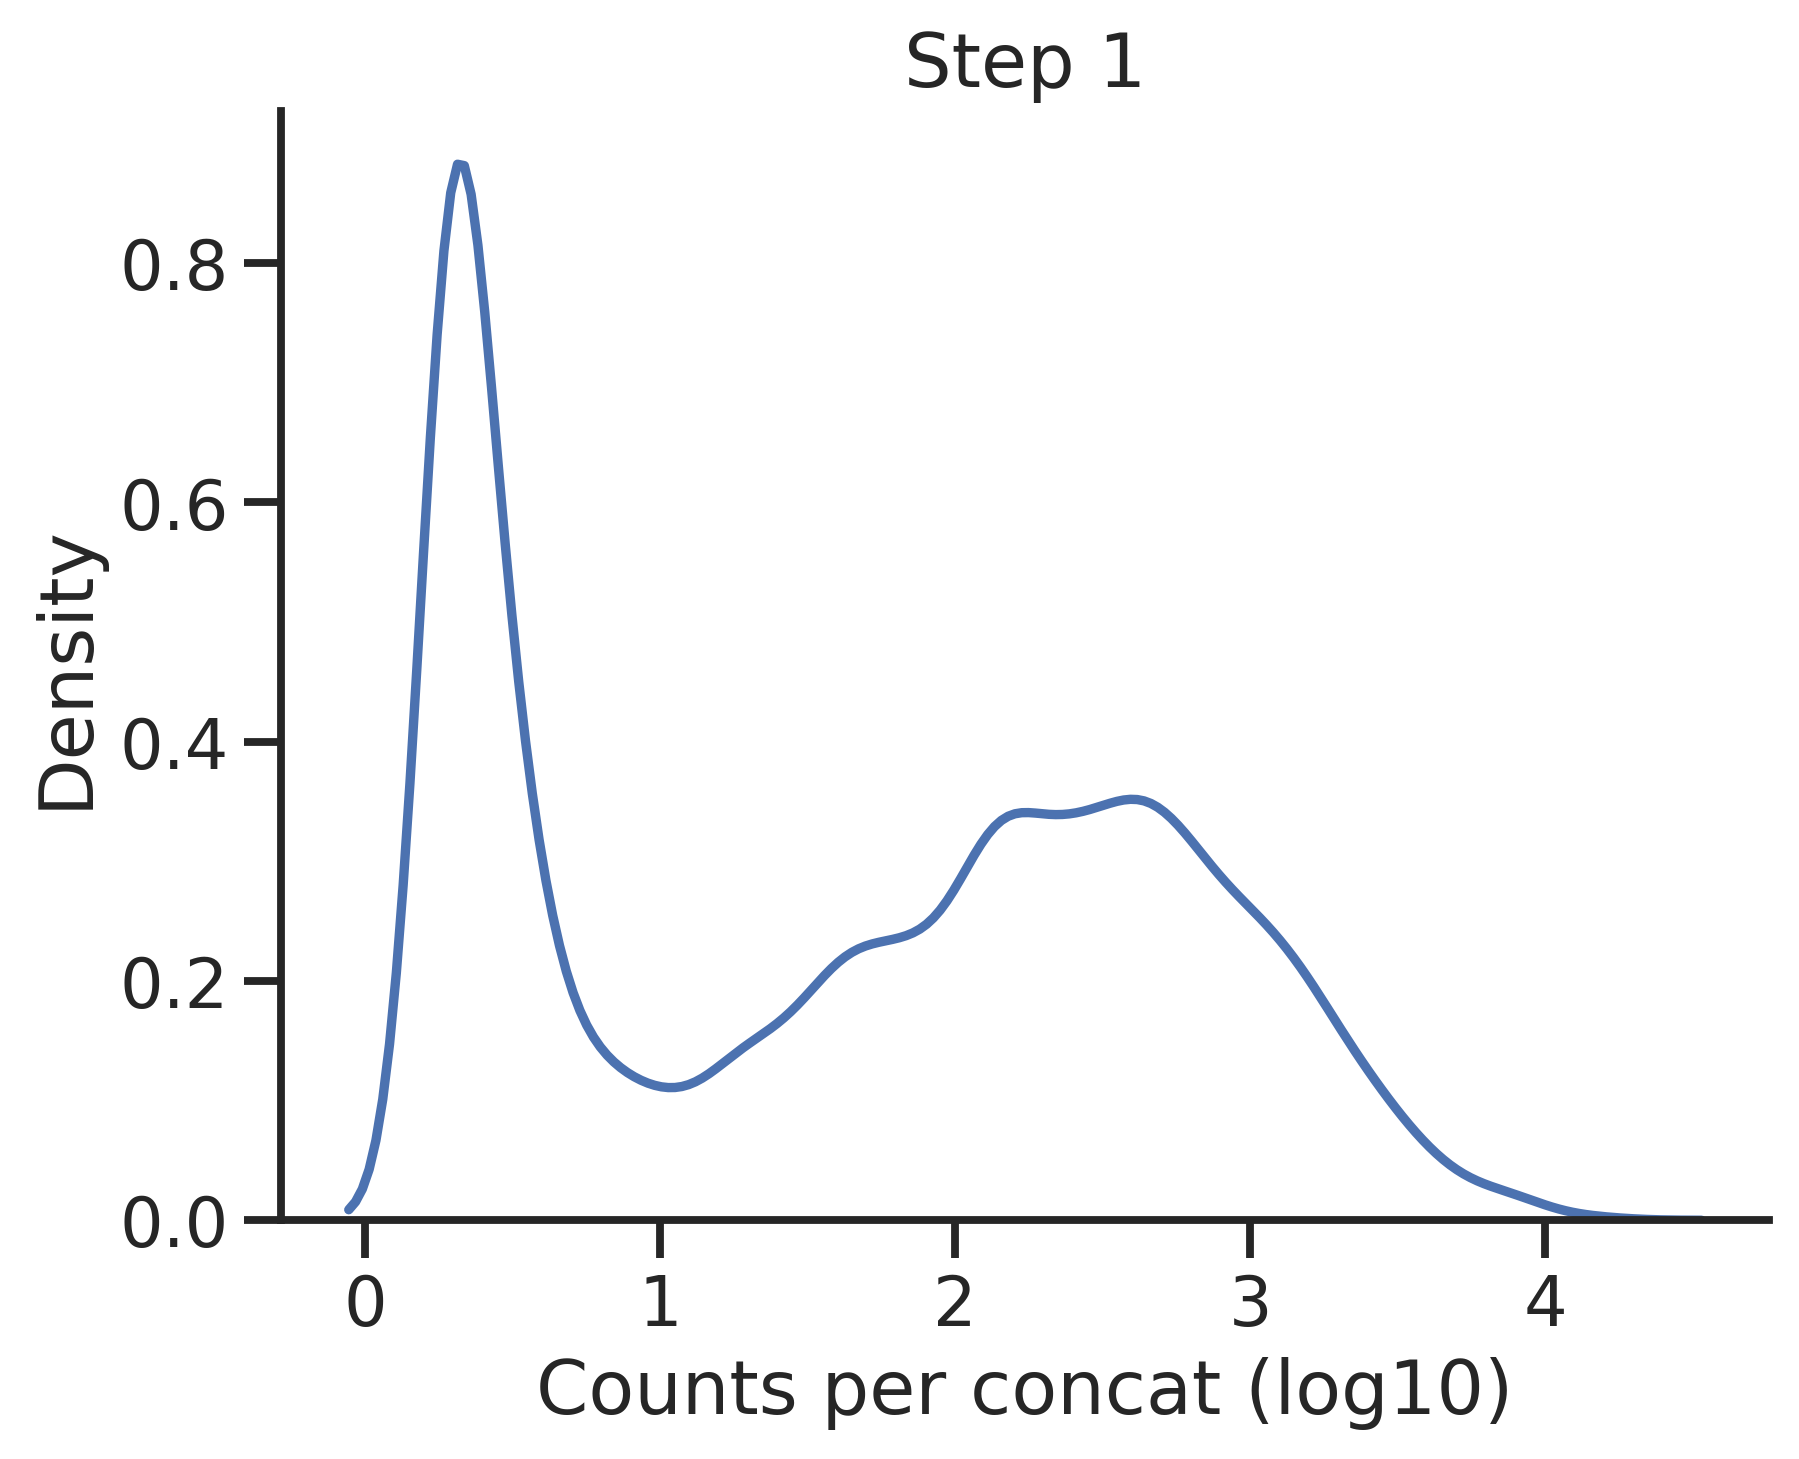

In [103]:
# Here is the strategy to get the same plot!
plt.figure(dpi = 300)
sns.set_context('talk')
plt.title("Step 1")
sns.kdeplot(extracted_barcodes_counts[extracted_barcodes_counts["log_count"] > 0]["log_count"], bw_adjust = 0.5)
plt.xlabel("Counts per concat (log10)")
sns.despine()

In [93]:
# Would the rank be better
extracted_barcodes_counts = extracted_barcodes_counts.reset_index()
extracted_barcodes_counts["cumul_sum"] = extracted_barcodes_counts["count"].cumsum()
extracted_barcodes_counts

,level_0,index,0,count,log_count,cumul_sum
0,0,0,AGGTTATCACAACTTC,14898,4.173128,14898
1,1,1,ACCATAACACCGATTG,11090,4.044932,25988
2,2,2,AGCCTGTCACAACTTC,8844,3.946649,34832
3,3,3,AAGACTACACAACTTC,8245,3.916191,43077
4,4,4,ACGAGTCCACAACTTC,7915,3.898451,50992
...,...,...,...,...,...,...
5149,5149,5149,ATCACTTAACCACGTG,1,0.000000,769914
5150,5150,5150,AACGATTCACGACCTC,1,0.000000,769915
5151,5151,5151,ACAAGTCCACAACTTC,1,0.000000,769916
5152,5152,5152,ACGATCCCACAACTTC,1,0.000000,769917


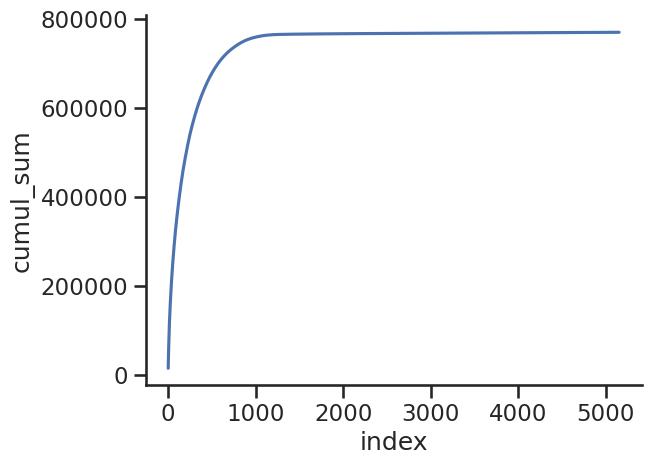

In [104]:
ax = sns.lineplot(data = extracted_barcodes_counts, x = "index", y = "cumul_sum")
sns.despine()

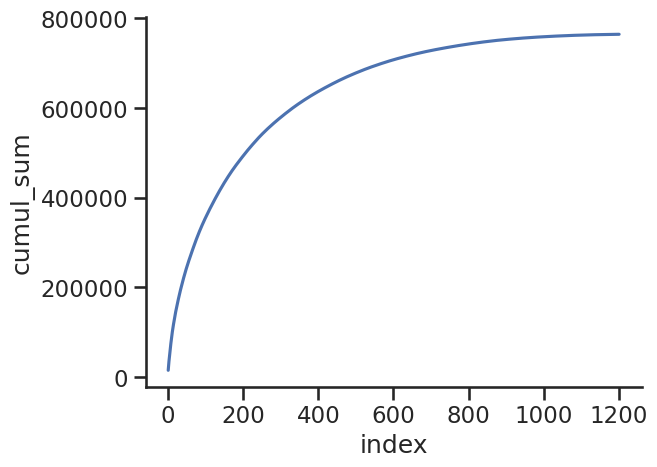

In [105]:
# Same thing here... UMI tools assumes the real reads threhsold is at least 10
ax = sns.lineplot(data = extracted_barcodes_counts[extracted_barcodes_counts["count"] > 10], x = "index", y = "cumul_sum")
sns.despine()

# New strategy: Rerun and manually set cell number

In [106]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# your data
x = extracted_barcodes_counts['index'].values
y = extracted_barcodes_counts['cumul_sum'].values

# first and last points
p1 = np.array([x[0], y[0]])
p2 = np.array([x[-1], y[-1]])


In [107]:
def distance_to_line(p, p1, p2):
    return np.abs((p2[1]-p1[1])*p[0] - (p2[0]-p1[0])*p[1] + p2[0]*p1[1] - p2[1]*p1[0]) / np.sqrt((p2[1]-p1[1])**2 + (p2[0]-p1[0])**2)

points = np.column_stack((x, y))
distances = np.array([distance_to_line(p, p1, p2) for p in points])


In [108]:
knee_index = np.argmax(distances)
knee_x = x[knee_index]
knee_y = y[knee_index]

print("Knee at index:", knee_index, "x value:", knee_x)


Knee at index: 747 x value: 747


1170

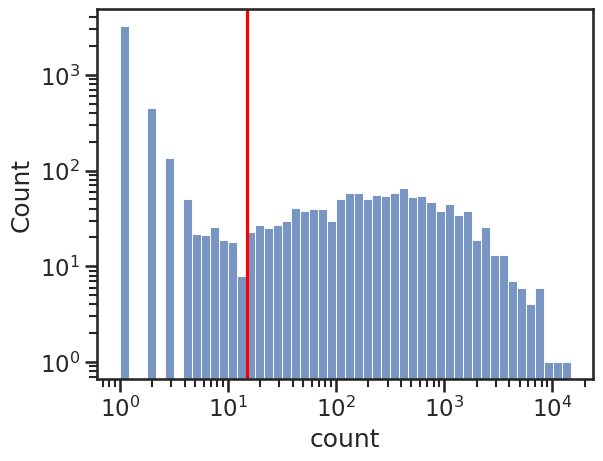

In [135]:
# What about a density based method? Since 10 is an inflection point
sns.histplot(extracted_barcodes_counts["count"], log_scale = (True, True), bins = 50)
plt.axvline(15, color = 'red')
density_bc_count = len(extracted_barcodes_counts[extracted_barcodes_counts["count"] > 15])
density_bc_count

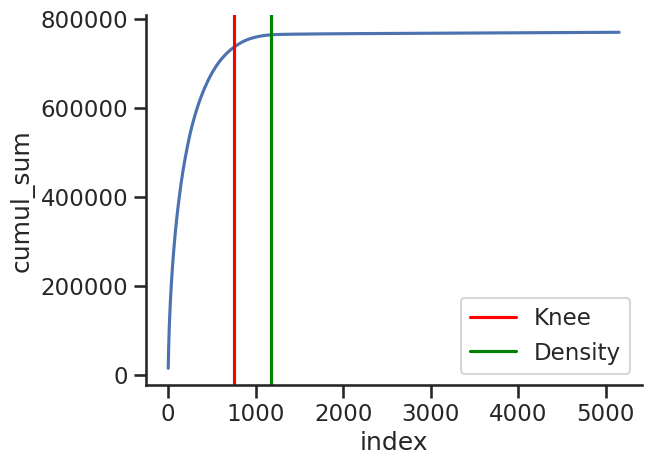

In [136]:
ax = sns.lineplot(data = extracted_barcodes_counts, x = "index", y = "cumul_sum")
sns.despine()
ax.axvline(knee_x, color = 'red', label = "Knee")
ax.axvline(density_bc_count, color = "green", label = "Density")
plt.legend()

In [137]:
# Will use my density based threshold of 15 reads / 1170 most abundant barcodes... lets see what happens

fastq_path = "/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist_concat/umi_a2_RNA_ADBC_S18/umi_a2_RNA_ADBC_S18_ADBC2_HawkBCs_filtered_barcodes_extracted.fastq"
output_dir = "/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist_concat/umi_a2_RNA_ADBC_S18/custom_threshold_try/"

error_correct.run_whitelist_on_concat_domains(fastq_path, output_dir, set_cell_number = density_bc_count)

Using custom cell number.
Running umi_tools whitelist on umi_a2_RNA_ADBC_S18_ADBC2_HawkBCs_filtered_barcodes_extracted.fastq ...
Whitelist complete.
- Log: /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist_concat/umi_a2_RNA_ADBC_S18/custom_threshold_try/umi_a2_RNA_ADBC_S18_ADBC2_HawkBCs_filtered_barcodes_extracted_whitelist.log
- Output: /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist_concat/umi_a2_RNA_ADBC_S18/custom_threshold_try/umi_a2_RNA_ADBC_S18_ADBC2_HawkBCs_filtered_barcodes_extracted_whitelist.txt
- Plots: /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist_concat/umi_a2_RNA_ADBC_S18/custom_threshold_try/umi_a2_RNA_ADBC_S18_ADBC2_HawkBCs_filtered_barcodes_extracted_plots_*.png


/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/conda/umi_tools/lib/python3.12/site-packages/umi_tools/whitelist_methods.py:207: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  fig3.set_xlim(0, len(counts)*1.25)



{'log': PosixPath('/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist_concat/umi_a2_RNA_ADBC_S18/custom_threshold_try/umi_a2_RNA_ADBC_S18_ADBC2_HawkBCs_filtered_barcodes_extracted_whitelist.log'),
 'whitelist': PosixPath('/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist_concat/umi_a2_RNA_ADBC_S18/custom_threshold_try/umi_a2_RNA_ADBC_S18_ADBC2_HawkBCs_filtered_barcodes_extracted_whitelist.txt'),
 'plot_prefix': PosixPath('/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist_concat/umi_a2_RNA_ADBC_S18/custom_threshold_try/umi_a2_RNA_ADBC_S18_ADBC2_HawkBCs_filtered_barcodes_extracted_plots')}

In [141]:
# New mapping
mapping_df = error_correct.convert_txt_to_whitelist_mapping_df_from_path("/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist_concat/umi_a2_RNA_ADBC_S18/custom_threshold_try/umi_a2_RNA_ADBC_S18_ADBC2_HawkBCs_filtered_barcodes_extracted_whitelist.txt")
mapping_df

,original,canonical
0,AAAAAAACTCTTGCA,AAAAAAACTCTTGCA
1,AAAAAAACTCCTGCA,AAAAAAACTCTTGCA
2,AAAAAAACTCGTGCA,AAAAAAACTCTTGCA
3,AAAAAAGCTCTTGCA,AAAAAAACTCTTGCA
4,AAAAAAATTCTCGCC,AAAAAAATTCTCGCC
...,...,...
4250,TCTTTTAGAGGAGTT,TTTTTTAGAGGAGTT
4251,TTTTTCAGAGGAGTT,TTTTTTAGAGGAGTT
4252,TTTTTTAGAGGCGTT,TTTTTTAGAGGAGTT
4253,TTTTTTAGAGGGGTT,TTTTTTAGAGGAGTT


In [143]:
# 5 times as many unique barocdes are represented!
len(mapping_df["canonical"].unique())

1170

In [139]:
# Compared to default threshold which was half of the length!
mapping_df_default = error_correct.convert_txt_to_whitelist_mapping_df_from_path("/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results_whitelist_concat/umi_a2_RNA_ADBC_S18/umi_a2_RNA_ADBC_S18_ADBC2_HawkBCs_filtered_barcodes_extracted_whitelist.txt")
mapping_df_default

,original,canonical
0,AAAAATCATCTTAGG,AAAAATCATCTTAGG
1,AAAAATCACCTTAGG,AAAAATCATCTTAGG
2,AAAAATCATATTAGG,AAAAATCATCTTAGG
3,AAAAATCATCCTAGG,AAAAATCATCTTAGG
4,AAAAATCATCGTAGG,AAAAATCATCTTAGG
...,...,...
2263,TCTTTTAGAGGAGTT,TTTTTTAGAGGAGTT
2264,TTTTTCAGAGGAGTT,TTTTTTAGAGGAGTT
2265,TTTTTTAGAGGCGTT,TTTTTTAGAGGAGTT
2266,TTTTTTAGAGGGGTT,TTTTTTAGAGGAGTT


In [144]:
len(mapping_df_default["canonical"].unique())

244

In [145]:
# How many unique barcodes did I start with?
extracted_barcodes_counts

,level_0,index,0,count,log_count,cumul_sum
0,0,0,AGGTTATCACAACTTC,14898,4.173128,14898
1,1,1,ACCATAACACCGATTG,11090,4.044932,25988
2,2,2,AGCCTGTCACAACTTC,8844,3.946649,34832
3,3,3,AAGACTACACAACTTC,8245,3.916191,43077
4,4,4,ACGAGTCCACAACTTC,7915,3.898451,50992
...,...,...,...,...,...,...
5149,5149,5149,ATCACTTAACCACGTG,1,0.000000,769914
5150,5150,5150,AACGATTCACGACCTC,1,0.000000,769915
5151,5151,5151,ACAAGTCCACAACTTC,1,0.000000,769916
5152,5152,5152,ACGATCCCACAACTTC,1,0.000000,769917


In [ ]:
# will run this command as an example